In [50]:
rm(list=ls())
user_name = Sys.info()['user']
temp_path = Sys.getenv()['TMP']
if (require('LalRUtils')==F) {
    library(devtools)
    devtools::install_github("apoorvalal/LalRUtils")
}
load_or_install(c('tidyverse','magrittr','sp',
            'rgeos','maptools','RColorBrewer',
            'ggmap','rgdal')) #, "lib2")
sessionInfo()

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

R version 3.3.2 (2016-10-31)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 15063)

locale:
[1] LC_COLLATE=English_United States.1252 
[2] LC_CTYPE=English_United States.1252   
[3] LC_MONETARY=English_United States.1252
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.1252    

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] bindrcpp_0.2         rgdal_1.2-8          ggmap_2.6.1         
 [4] RColorBrewer_1.1-2   maptools_0.8-39      rgeos_0.3-23        
 [7] sp_1.2-3             magrittr_1.5         dplyr_0.7.1         
[10] purrr_0.2.2          readr_1.0.0          tidyr_0.6.1         
[13] tibble_1.3.3         ggplot2_2.2.1        tidyverse_1.1.1     
[16] LalRUtils_0.0.0.9000 jsonlite_1.0        

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.8         lubridate_1.5.6     lattice_0.20-34    
 [4] png_0.1-7           a

In [51]:
# all data is online
dist = readRDS(gzcon(url('http://biogeo.ucdavis.edu/data/gadm2.8/rds/NPL_adm3.rds')))
vdc  = readRDS(gzcon(url('http://biogeo.ucdavis.edu/data/gadm2.8/rds/NPL_adm4.rds')))
census_data=readr::read_csv('https://raw.githubusercontent.com/apoorvalal/census-data/master/districts_complete.csv')
names(census_data) = tolower(names(census_data))

Warning message:
"Duplicated column names deduplicated: 'OTHERS' => 'OTHERS_1' [17], 'NOT_STATED' => 'NOT_STATED_1' [18], 'OTHERS' => 'OTHERS_2' [23], 'NOT_STATED' => 'NOT_STATED_2' [24], 'NOT_STATED' => 'NOT_STATED_3' [39], 'ELECTRICITY' => 'ELECTRICITY_1' [46], 'KEROSENE' => 'KEROSENE_1' [47], 'BIOGAS' => 'BIOGAS_1' [48], 'OTHERS' => 'OTHERS_3' [50], 'NOT_STATED' => 'NOT_STATED_4' [51], 'MUD_BONDED' => 'MUD_BONDED_1' [52], 'CEMENT_BONDED' => 'CEMENT_BONDED_1' [53], 'OTHERS' => 'OTHERS_4' [57], 'NOT_STATED' => 'NOT_STATED_5' [58], 'OTHERS' => 'OTHERS_5' [62], 'NOT_STATED_BOTH_SEX' => 'NOT_STATED_BOTH_SEX_1' [143], 'NOT_STATED_MALE' => 'NOT_STATED_MALE_1' [144], 'NOT_STATED_FEMALE' => 'NOT_STATED_FEMALE_1' [145], 'WOOD_PLANKS' => 'WOOD_PLANKS_1' [153], 'OTHERS' => 'OTHERS_6' [155], 'NOT_STATED' => 'NOT_STATED_6' [156], 'NOT_STATED' => 'NOT_STATED_7' [160]"Parsed with column specification:
cols(
  .default = col_integer(),
  DISTRICT = col_character(),
  `VDC/MUNICIPALITY` = col_charact

### Outlines

Regions defined for each Polygons


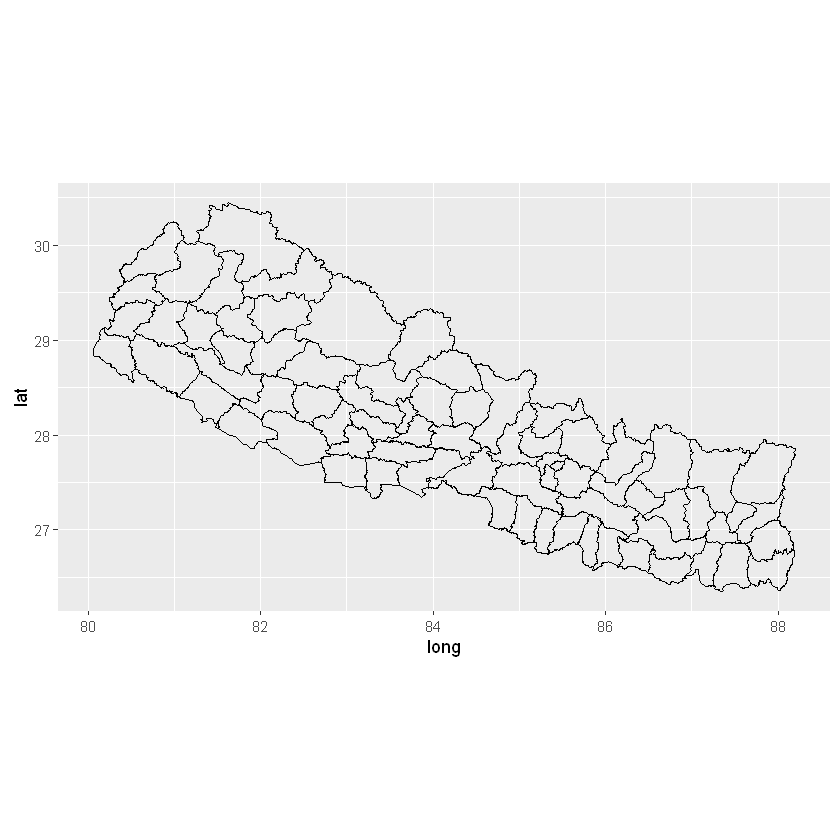

In [6]:
ggplot(data=dist)+geom_path(aes(x=long,y=lat,group=group))+coord_fixed(1.1)

Regions defined for each Polygons


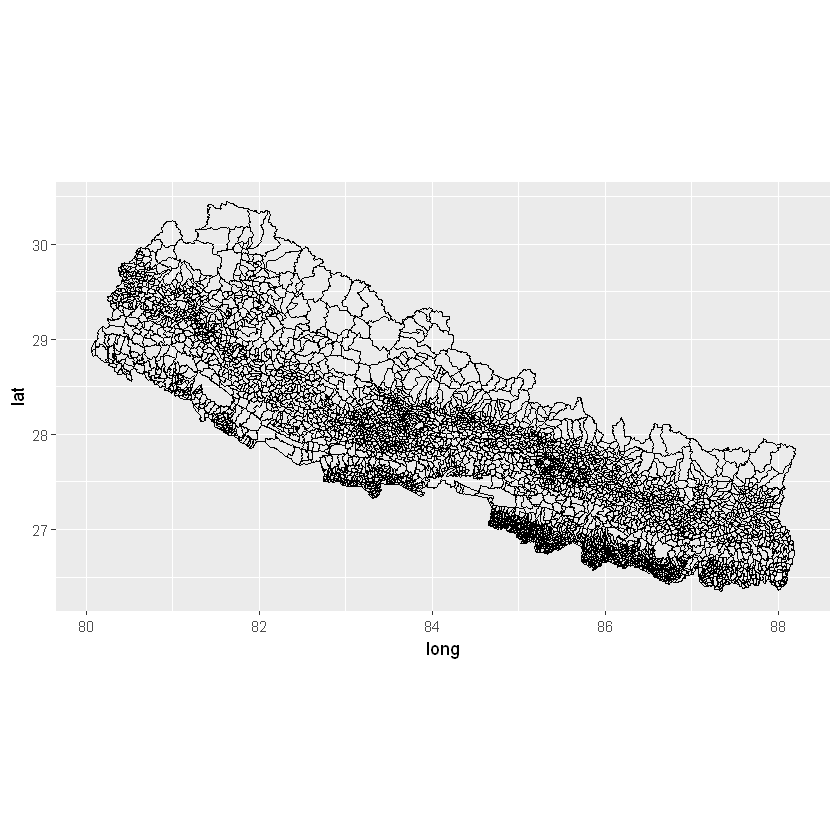

In [3]:
ggplot(data=vdc)+geom_path(aes(x=long,y=lat,group=group))+coord_fixed(1.1)

### Prep census data for merge

In [52]:
dist$NAME_3 = tolower(dist$NAME_3)

In [53]:
dist$NAME_3 = tolower(dist$NAME_3)
dist_shp <- fortify(dist, region = "NAME_3")
dist_shp %>%
     mutate(id=replace(id,id== "chitawan"      ,"chitwan")) %>%
     mutate(id=replace(id,id== "dhanusa"       ,"dhanusha")) %>%
     mutate(id=replace(id,id== "ilam"          ,"illam")) %>%
     mutate(id=replace(id,id== "kavrepalanchok","kavre")) %>%
     mutate(id=replace(id,id== "makwanpur"     ,"makawanpur")) %>%
     mutate(id=replace(id,id== "sindhupalchok" ,"sindhupalchowk")) %>%
     mutate(id=replace(id,id== "terhathum"     ,"tehrathum")) ->
    dist_shp_ren

For each district $d$, Sex Ratio is defined as
$$
    \text{Sex Ratio}_{d} = \frac{\sum_{i \in d} S_{i} == F}{\sum_{i \in d} S_{i} == M}
$$

In [54]:
census_data %>%
    mutate(district = tolower(district),
        `vdc/municipality` = tolower(`vdc/municipality`),
        sr_rebase = (female_population/male_population)*1000)%>%
   rename(vdc=`vdc/municipality`)->
    clean_master

### Aggregate Census data to District

In [55]:
clean_master  %>%
    mutate(gender_diff_literacy = literacy_rate_male-literacy_rate_female)  %>% 
    group_by(district)  %>%
    summarize(literacy=mean(literacy_rate_both_sex),
           male_literacy=mean(literacy_rate_male),
           female_literacy=mean(literacy_rate_female),
           diff_literacy=mean(gender_diff_literacy)) ->
    dist_lev_literacy
head(dist_lev_literacy)
dim(dist_lev_literacy)

district,literacy,male_literacy,female_literacy,diff_literacy
achham,56.67583,72.02267,43.98457,28.03810
arghakhanchi,72.15724,81.42333,65.54226,15.88107
baglung,71.00933,79.82789,64.56314,15.26474
baitadi,62.81684,78.98610,49.13563,29.85047
bajhang,56.16457,73.95553,40.67472,33.28080
bajura,54.50050,67.80749,42.26080,25.54669


[1] 74  5

In [56]:
clean_master %>%
    group_by(district)%>%
    summarise(dist_population = sum(total_population),
              dist_male_population = sum(male_population),
              dist_female_population = sum(female_population),
              dist_sex_ratio = mean(sr_rebase)) ->
    district_populations
head(district_populations)
dim(district_populations)

district,dist_population,dist_male_population,dist_female_population,dist_sex_ratio
achham,256188,118775,137413,1174.714
arghakhanchi,196895,85550,111345,1339.979
baglung,266630,116395,150235,1316.915
baitadi,250225,116763,133462,1155.376
bajhang,194701,92345,102356,1122.665
bajura,134154,65078,69076,1065.396


[1] 74  5

In [57]:
# merge district level literacy figures with fortified shapefile
dist_literacy_geo = merge(dist_shp_ren,dist_lev_literacy,
                    by.x='id',by.y='district',all.x=T)
dist_literacy_geo %<>% arrange(order)
cnames <- aggregate(cbind(long, lat) ~ id, data=dist_literacy_geo, 
                    FUN=function(x) mean(range(x)))

### Literacy Maps

Warning message:
"`panel.margin` is deprecated. Please use `panel.spacing` property instead"

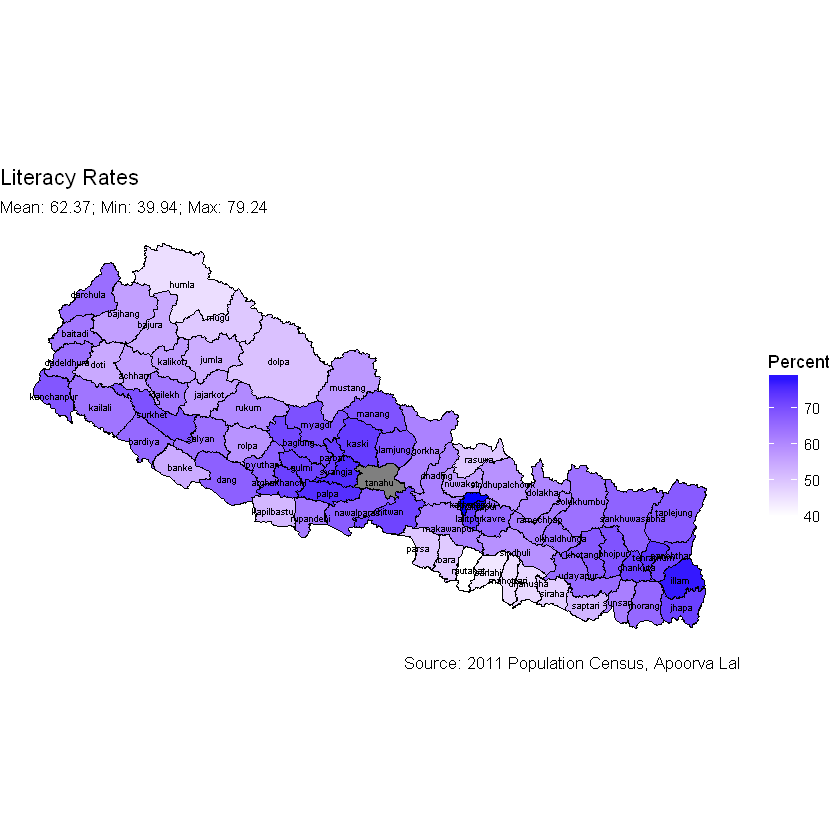

In [58]:
lit = ggplot(data=dist_literacy_geo) +
    geom_polygon(aes(x=long,y=lat,group = id,fill=literacy)) +
    geom_path(aes(x=long,y=lat,group = id)) +
    coord_map()+
    theme_nothing(legend = TRUE)+
    scale_fill_gradient(name="Percent",low="white", high="blue")+
    geom_text(data=cnames, aes(long, lat, label = id), size=2)+
    labs(title = "Literacy Rates",
       subtitle = paste0('Mean: ',
                         summary(dist_lev_literacy$literacy)['Mean'],
                        '; Min: ',
                         summary(dist_lev_literacy$literacy)['Min.'],
                        '; Max: ',
                         summary(dist_lev_literacy$literacy)['Max.']),
       caption = "Source: 2011 Population Census, Apoorva Lal")
lit

Warning message:
"`panel.margin` is deprecated. Please use `panel.spacing` property instead"Warning message:
"`panel.margin` is deprecated. Please use `panel.spacing` property instead"

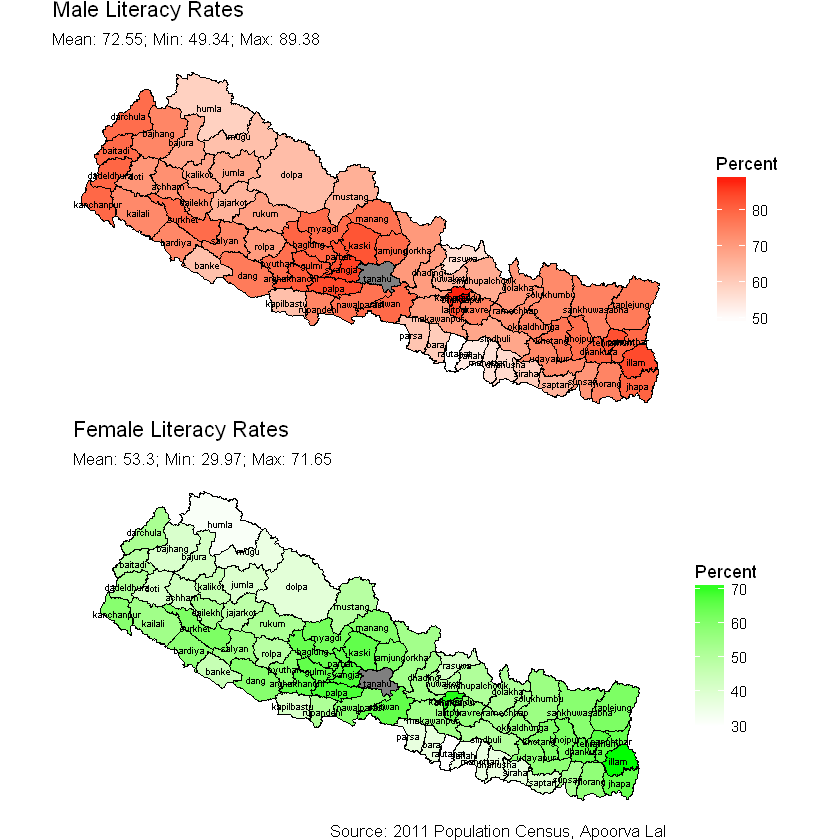

In [60]:
mlit = ggplot(data=dist_literacy_geo) +
    geom_polygon(aes(x=long,y=lat,group = id,fill=male_literacy)) +
    geom_path(aes(x=long,y=lat,group = id)) +
    coord_map()+
    theme_nothing(legend = TRUE)+
    scale_fill_gradient(name="Percent",low="white", high="red")+
    geom_text(data=cnames, aes(long, lat, label = id), size=2)+
    labs(title = "Male Literacy Rates",
       subtitle = paste0('Mean: ',summary(dist_lev_literacy$male_literacy)['Mean'],
                        '; Min: ',summary(dist_lev_literacy$male_literacy)['Min.'],
                        '; Max: ',summary(dist_lev_literacy$male_literacy)['Max.']))

flit = ggplot(data=dist_literacy_geo) +
    geom_polygon(aes(x=long,y=lat,group = id,fill=female_literacy)) +
    geom_path(aes(x=long,y=lat,group = id)) +
    coord_map()+
    theme_nothing(legend = TRUE)+
    scale_fill_gradient(name="Percent",low="white", high="green")+
    geom_text(data=cnames, aes(long, lat, label = id), size=2)+
    labs(title = "Female Literacy Rates",
       subtitle = paste0('Mean: ',summary(dist_lev_literacy$female_literacy)['Mean'],
                        '; Min: ',summary(dist_lev_literacy$female_literacy)['Min.'],
                        '; Max: ',summary(dist_lev_literacy$female_literacy)['Max.']),
       caption = "Source: 2011 Population Census, Apoorva Lal")

multiplot(mlit,flit,cols=1)


Warning message:
"`panel.margin` is deprecated. Please use `panel.spacing` property instead"

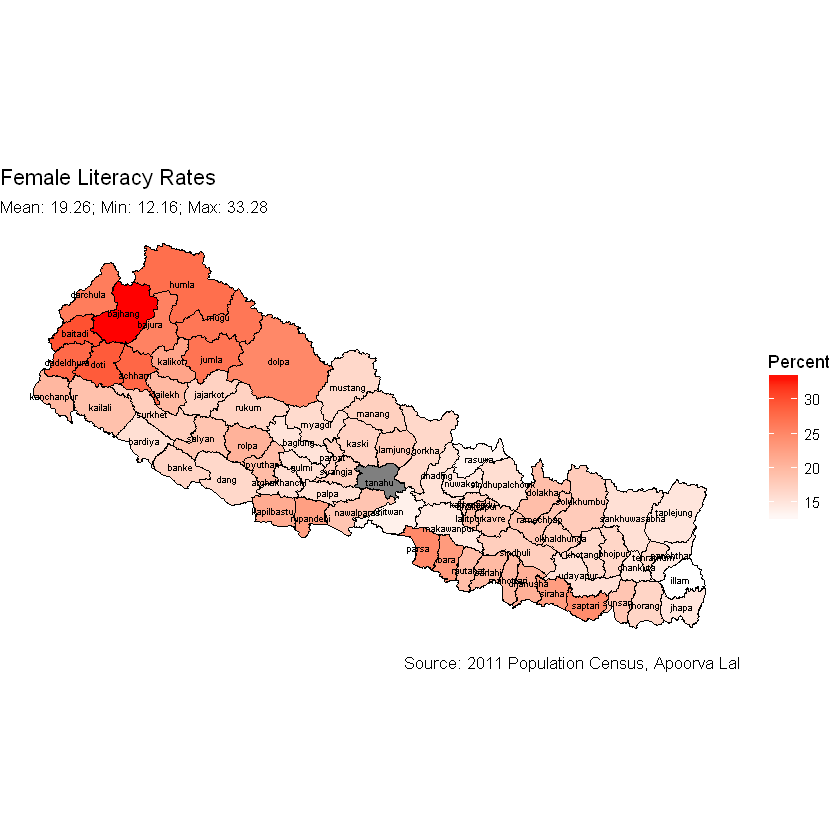

In [61]:
ggplot(data=dist_literacy_geo) +
    geom_polygon(aes(x=long,y=lat,group = id,fill=diff_literacy)) +
    geom_path(aes(x=long,y=lat,group = id)) +
    coord_map()+
    theme_nothing(legend = TRUE)+
    scale_fill_gradient(name="Percent",low="white", high="red")+
    geom_text(data=cnames, aes(long, lat, label = id), size=2)+
        labs(title = "Female Literacy Rates",
       subtitle = paste0('Mean: ',summary(dist_lev_literacy$diff_literacy)['Mean'],
                        '; Min: ',summary(dist_lev_literacy$diff_literacy)['Min.'],
                        '; Max: ',summary(dist_lev_literacy$diff_literacy)['Max.']),
       caption = "Source: 2011 Population Census, Apoorva Lal")

### Sex ratio maps

In [62]:
# Map all districts
dist_sr_geo = left_join(dist_shp_ren,district_populations,
                    by=c('id'='district'))

dist_sr_geo %<>% arrange(order)
# names for map labels
cnames <- aggregate(cbind(long, lat) ~ id, data=dist_sr_geo,
    FUN=function(x) mean(range(x)))

Warning message:
"`panel.margin` is deprecated. Please use `panel.spacing` property instead"

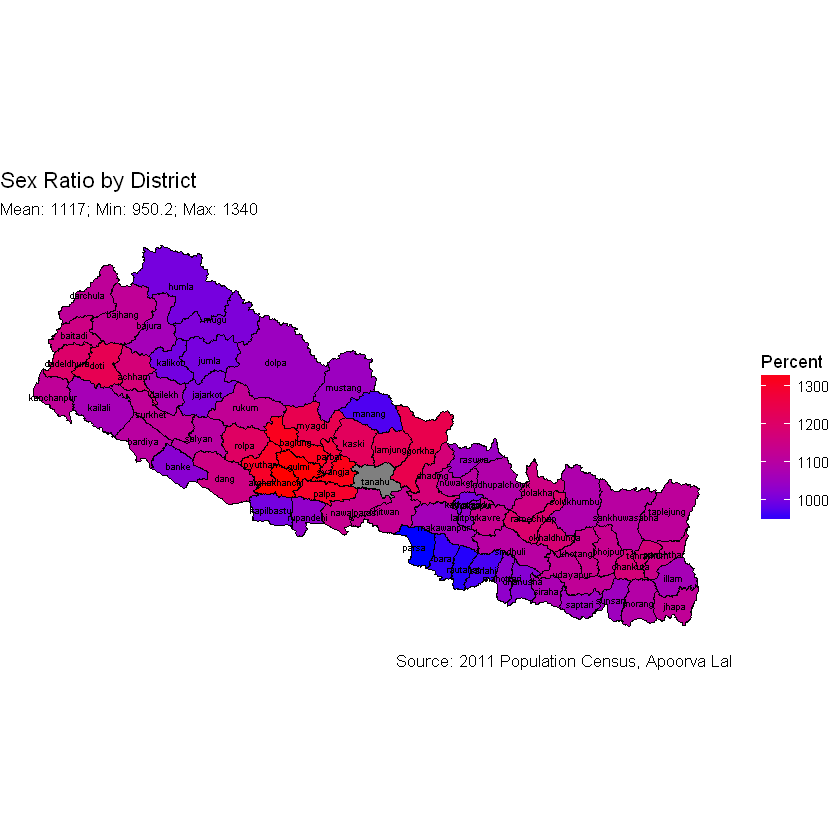

In [63]:
map = ggplot(data=dist_sr_geo) +
    geom_polygon(aes(x=long,y=lat,group = id,fill=dist_sex_ratio)) +
    geom_path(aes(x=long,y=lat,group = id)) +
    coord_map()+
    theme_nothing(legend = TRUE)  +
    scale_fill_gradient(name="Percent",low="blue", high="red")+
    geom_text(data=cnames, aes(long, lat, label = id), size=2)

map +
  labs(title = "Sex Ratio by District",
       subtitle = paste0('Mean: ',
                         summary(district_populations$dist_sex_ratio)['Mean'],
                        '; Min: ',
                         summary(district_populations$dist_sex_ratio)['Min.'],
                        '; Max: ',
                         summary(district_populations$dist_sex_ratio)['Max.']),
       caption = "Source: 2011 Population Census, Apoorva Lal")


#### Zoom into central cluster of districts with very high ratios 

In [64]:
central_districts <- c('pyuthan','arghakhanchi','palpa','gulmi',
                    'baglung','parbat','syangja','myagdi','rolpa',
                      'kaski','lamjung','gorkha')

district_populations %>%
    filter(district %in% central_districts) ->
    central_populations

central_populations$district %in% dist_shp_ren$id

central_sr_dist_geo = inner_join(central_populations,
                                dist_shp_ren,
                                by=c('district'='id'))

central_sr_dist_geo %<>% arrange(order)
# names for map labels
cnames <- aggregate(cbind(long, lat) ~ district, data=central_sr_dist_geo,
    FUN=function(x) mean(range(x)))

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

##### district level

Warning message:
"`panel.margin` is deprecated. Please use `panel.spacing` property instead"

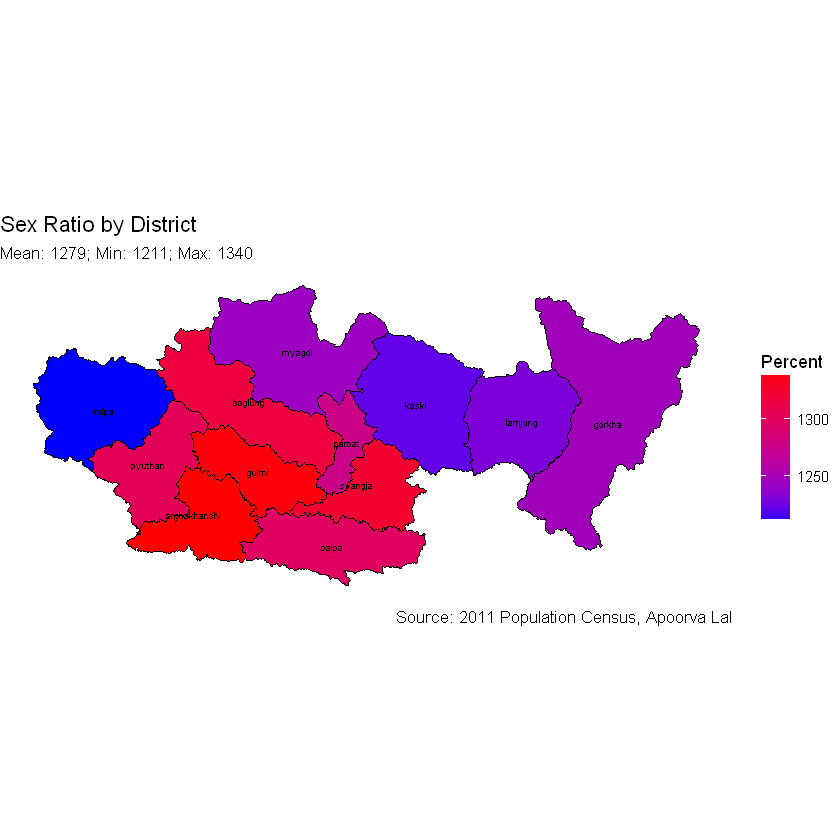

In [65]:
map = ggplot(data=central_sr_dist_geo) +
    geom_polygon(aes(x=long,y=lat,group = district,fill=dist_sex_ratio)) +
    geom_path(aes(x=long,y=lat,group = district)) +
    coord_map()+
    theme_nothing(legend = TRUE)  +
    scale_fill_gradient(name="Percent",low="blue", high="red")+
    geom_text(data=cnames, aes(long, lat, label = district), size=2)

map +
  labs(title = "Sex Ratio by District",
       subtitle = paste0('Mean: ',summary(central_populations$dist_sex_ratio)['Mean'],
                        '; Min: ',summary(central_populations$dist_sex_ratio)['Min.'],
                        '; Max: ',summary(central_populations$dist_sex_ratio)['Max.']),
       caption = "Source: 2011 Population Census, Apoorva Lal")

##### Village level - absolute mess

In [66]:
clean_master %>% filter(district %in% central_districts) %>%
    group_by(vdc)%>%
    summarise(vdc_population = sum(total_population),
              vdc_male_population = sum(male_population),
              vdc_female_population = sum(female_population),
              vdc_sex_ratio = mean(sr_rebase)) ->
    central

# subset shapefile
vdc$NAME_3 = tolower(vdc$NAME_3)
vdc$NAME_4 = tolower(vdc$NAME_4)

central_vdcs <- vdc[vdc$NAME_3 %in% central_districts,]
vdc_shp <- fortify(central_vdcs, region = "NAME_4")

# match vdc names
census_vdcs = sort(unique(central$vdc))
map_vdcs    = sort(unique(vdc_shp$id))
length(census_vdcs)
length(map_vdcs)

[1] 659

[1] 659

In [67]:
vdc_central_geo = inner_join(central, vdc_shp,
                    by=c('vdc'='id'))

vdc_central_geo %<>% arrange(order)
cnames <- aggregate(cbind(long, lat) ~ vdc, data=vdc_central_geo,
    FUN=function(x) mean(range(x)))

Warning message:
"`panel.margin` is deprecated. Please use `panel.spacing` property instead"

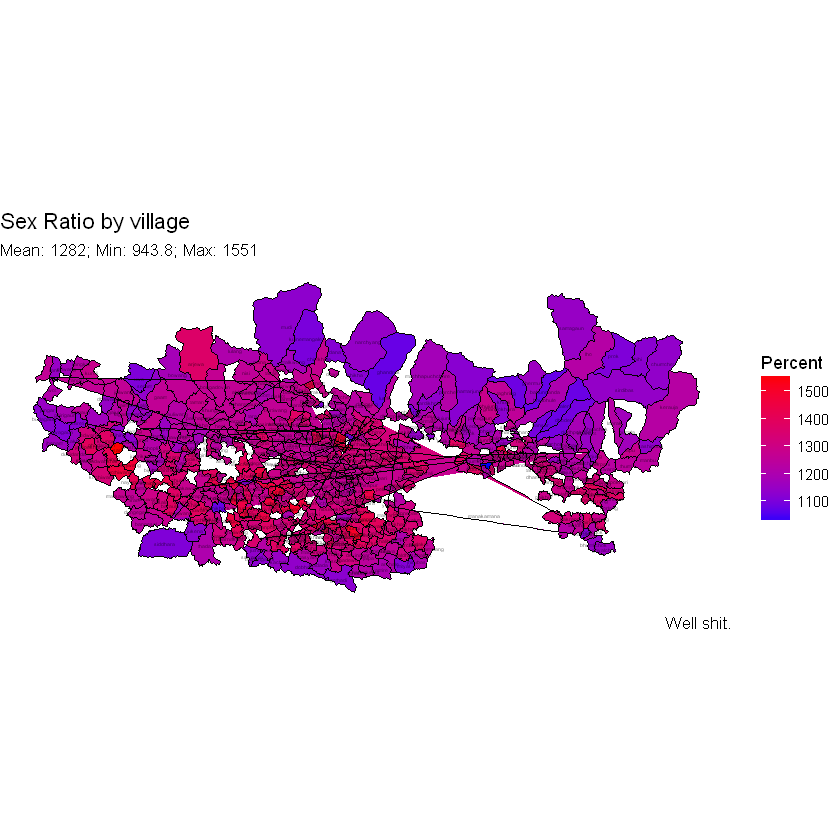

In [68]:
map = ggplot(data=vdc_central_geo) +
    geom_polygon(aes(x=long,y=lat,group = vdc,fill=vdc_sex_ratio)) +
    geom_path(aes(x=long,y=lat,group = vdc)) +
    coord_map()+
    theme_nothing(legend = TRUE)  +
    scale_fill_gradient(name="Percent",low="blue", high="red")+
    geom_text(data=cnames, aes(long, lat, label = vdc), size=1)

map +
  labs(title = "Sex Ratio by village",
       subtitle = paste0('Mean: ',
                        summary(central$vdc_sex_ratio)['Mean'],
                        '; Min: ',
                        summary(central$vdc_sex_ratio)['Min.'],
                        '; Max: ',
                        summary(central$vdc_sex_ratio)['Max.']),
       caption = "Well shit.")